# Introduction

Dans le cadre de ce projet, nous nous engageons dans la conception avancée d'un système de recommandation pour les animes de MyAnimeList (MAL). Notre initiative est guidée par une approche méthodique, exploitant des techniques d'apprentissage supervisé et non supervisé pour affiner la précision des suggestions offertes aux utilisateurs. L'objectif fondamental est d'exploiter de manière optimale les vastes ensembles de données disponibles sur MAL, afin de générer des recommandations qui sont à la fois personnalisées et contextuellement pertinentes.

Notre stratégie s'articule autour d'une fusion harmonieuse de deux paradigmes de recommandation primordiaux : le Collaborative Filtering et le Content-Based Filtering. Le premier s'appuie sur une analyse approfondie des interactions et des préférences des utilisateurs, formant ainsi la base d'une recommandation axée sur la communauté. Par contraste, le Content-Based Filtering se concentre sur les attributs intrinsèques des animes eux-mêmes, visant à identifier et à suggérer des titres ayant des caractéristiques similaires.

Au-delà de ces approches, notre exploration s'étendra à diverses méthodes analogues. Ces techniques supplémentaires seront soigneusement intégrées pour renforcer la pertinence et l'exactitude des recommandations. L'ambition ultime de ce projet est de forger un système de recommandation qui ne se contente pas de refléter les préférences actuelles des utilisateurs, mais qui est également capable d'anticiper et de satisfaire leur curiosité pour des animes inexplorés, enrichissant ainsi leur expérience de découverte.

In [484]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fitter import Fitter

from scipy.stats import pearsonr, kruskal

import html
import warnings
import pickle
import re
import os
from collections import defaultdict

from surprise import accuracy
from surprise import Reader
from surprise import Dataset, accuracy
from surprise.model_selection import train_test_split, LeaveOneOut
from surprise import AlgoBase
from surprise import PredictionImpossible
from surprise.prediction_algorithms import KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore
from surprise.prediction_algorithms import NMF, SVD, SVDpp
from surprise.prediction_algorithms import SlopeOne, CoClustering
from surprise.model_selection import GridSearchCV, cross_validate, KFold

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors

from fuzzywuzzy import fuzz

In [483]:
!pip install fuzzywuzzy


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
warnings.filterwarnings("ignore")

In [3]:
!pip install fitter

# Anime Dataset
## Importation et description des données

In [4]:
anime_df = pd.read_csv(r'../data/anime.csv', encoding='utf-8')

anime_df = anime_df.applymap(lambda x: html.unescape(x) if isinstance(x, str) else x)
anime_df.head(20)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama',"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama': Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [5]:
anime_df.shape

(12294, 7)

In [6]:
anime_df.columns.tolist()

['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']

In [7]:
anime_df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [8]:
anime_df_unique = {
    col: anime_df[col].unique().tolist()
    for col in anime_df[['type', 'genre']].columns
}

anime_df_unique

{'type': ['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan],
 'genre': ['Drama, Romance, School, Supernatural',
  'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
  'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
  'Sci-Fi, Thriller',
  'Comedy, Drama, School, Shounen, Sports',
  'Action, Adventure, Shounen, Super Power',
  'Drama, Military, Sci-Fi, Space',
  'Drama, Fantasy, Romance, Slice of Life, Supernatural',
  'Drama, School, Shounen',
  'Action, Drama, Mecha, Military, Sci-Fi, Super Power',
  'Adventure, Drama, Supernatural',
  'Drama, Music, Romance, School, Shounen',
  'Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural',
  'Fantasy, Slice of Life',
  'Action, Mecha, Military, School, Sci-Fi, Super Power',
  'Comedy, Drama, Shounen, Sports',
  'Action, Drama, Historical, Martial Arts, Romance, Samurai',
  'Action, Adventure, Comedy, Drama, Sci-Fi, Space',
  'Action, Comedy, Parody, Sci-Fi, Seinen, Super Power, Superna

## Imputation et suppression des données manquantes et dupliquées

In [9]:
unknown_number_episodes = anime_df[anime_df == "Unknown"].count()

missing_rate = pd.DataFrame({
                             'count': (anime_df.isna().sum() + unknown_number_episodes),
                             'rate': (anime_df.isna().sum() * 100 / anime_df.shape[0]) 
                                      + (unknown_number_episodes * 100 / anime_df.shape[0])
                             }).sort_values(by = 'rate', ascending = False)
missing_rate

,count,rate
episodes,340,2.765577
rating,230,1.870831
genre,62,0.504311
type,25,0.203351
anime_id,0,0.000000
name,0,0.000000
members,0,0.000000


In [10]:
nan_ratings = anime_df[anime_df.rating.isna()]
nan_ratings

,anime_id,name,genre,type,episodes,rating,members
8968,34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,Unknown,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,Unknown,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,Unknown,NaN,90706
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999
...,...,...,...,...,...,...,...
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,OVA,Unknown,NaN,392
12279,34491,Sagurare Otome The Animation,Hentai,OVA,1,NaN,79
12280,34312,Saimin Class,Hentai,OVA,Unknown,NaN,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,NaN,195


In [11]:
anime_df[anime_df.duplicated()]

,anime_id,name,genre,type,episodes,rating,members


In [12]:
anime_df.dropna(inplace=True)
anime_df.drop(anime_df.loc[anime_df.episodes == 'Unknown'].index, inplace=True)

anime_df.episodes = anime_df.episodes.astype(int)

## Calcul des variables de rang par popularité et par note moyenne

In [13]:
anime_df.rating_rank = anime_df.rating.rank(ascending=False, method="min")
anime_df.members_rank = anime_df.members.rank(ascending=False, method="min")

## Analyse descriptive et exploratoire genre par genre

### Exploration des genres uniques et déconstruction des genres composés

In [14]:
single_genre = anime_df[anime_df.genre.str.count(",") == 0]
single_genre_counts = single_genre.genre.value_counts()
single_genre_counts

genre
Hentai           785
Comedy           500
Music            297
Kids             190
Dementia         137
Fantasy          110
Drama            104
Slice of Life     96
Adventure         78
Historical        67
Action            53
Sci-Fi            41
Sports            40
Ecchi             21
Magic             20
Horror            18
Mystery           18
Mecha             17
Romance           14
Supernatural      14
Psychological     13
Game              10
Shoujo             9
Shounen            9
School             7
Parody             6
Cars               5
Seinen             3
Harem              2
Samurai            2
Military           2
Demons             2
Yaoi               2
Thriller           1
Martial Arts       1
Vampire            1
Space              1
Name: count, dtype: int64

In [15]:
exploded_genre_df = anime_df.assign(unique_genre=anime_df['genre'].str.split(", ")).explode('unique_genre')
exploded_genre_df.reset_index(inplace=True)
exploded_genre_df.drop(columns='index', inplace=True)
exploded_genre_df.unique_genre

0               Drama
1             Romance
2              School
3        Supernatural
4              Action
             ...     
35196          Hentai
35197          Hentai
35198          Hentai
35199          Hentai
35200          Hentai
Name: unique_genre, Length: 35201, dtype: object

In [16]:
anime_genre_counts = exploded_genre_df.unique_genre.value_counts()
anime_genre_counts

unique_genre
Comedy           4483
Action           2748
Adventure        2293
Fantasy          2219
Sci-Fi           2028
Drama            1972
Shounen          1669
Kids             1550
Romance          1436
Slice of Life    1180
School           1164
Hentai           1099
Supernatural      993
Mecha             927
Music             832
Historical        787
Magic             742
Ecchi             627
Shoujo            587
Seinen            530
Sports            527
Mystery           482
Super Power       445
Military          415
Parody            397
Space             376
Horror            360
Harem             312
Demons            287
Martial Arts      258
Dementia          238
Psychological     226
Police            194
Game              170
Samurai           145
Vampire           100
Thriller           86
Cars               71
Shounen Ai         62
Shoujo Ai          54
Josei              52
Yuri               41
Yaoi               37
Name: count, dtype: int64

In [17]:
df_expanded = anime_df.drop("genre", axis=1).join(
    anime_df.genre
    .str.split(", ", expand=True)
    .stack()
    .reset_index(level=1, drop=True)
    .rename("genre")
)
stats_par_genre = df_expanded.groupby("genre").agg(
    {
        "rating": ["mean", "count"],
        "members": "sum",
    }
)
stats_par_genre.columns = [
    "rating_moyen",
    "nombre_notes",
    "membres_somme",
]

stats_par_genre["membres_somme"] = stats_par_genre["membres_somme"].round(1)
stats_par_genre["genre_rating_rank"] = stats_par_genre["rating_moyen"].rank(
    ascending=False, method="min"
)
stats_par_genre["genre_members_rank"] = stats_par_genre["membres_somme"].rank(
    ascending=False, method="min"
)
stats_par_genre["genre_rating_rank"] = stats_par_genre["genre_rating_rank"].astype(int)
stats_par_genre["genre_members_rank"] = stats_par_genre["genre_members_rank"].astype(
    int
)

stats_par_genre.sort_values(by="rating_moyen", ascending=False)

,rating_moyen,nombre_notes,membres_somme,genre_rating_rank,genre_members_rank
genre,,,,,
Josei,7.443077,52,2203920,1,37
Thriller,7.382326,86,10072531,2,24
Mystery,7.233880,482,26697384,3,12
Police,7.116237,194,4769176,4,33
Shounen,7.055848,1669,52358640,5,8
Psychological,7.010398,226,17176263,6,18
Military,7.006193,415,12148845,7,22
Supernatural,7.004340,993,56456163,8,5
Romance,6.999554,1436,65405383,9,3


Le dataset a 12294 enregistrements.
* anime_id : On a bien une valeur unique par ligne, il n'y a donc pas de doublons, ni de valeurs manquantes pour identifier l'anime. Pour 12294 entrées.
* name : bien qu'ayant des identifiants (anime_id) différents, il y a deux doublons, deux références ayant le même nom : "Saru Kani Gassen" et "Shi Wan Ge Leng Xiaohua", on remarque cependant qu'il s'agit de type différents, respectivement : "OVA" et "Movie", "ONA" et "Movie". Il s'agit donc bien d'oeuvres différentes.
* genre : il y a 62 valeurs manquantes pour le genre, ce qui représente 0,50% du total. Les genres manquants sont issus de différents types d'oeuvres, il ne semble pas y avoir de raison systémique à ces informations manquantes. Certaines oeuvres contiennent une liste de genre pour cette colonne, il faut donc la décomposer pour l'analyser. La décomposition révêle qu'il y a 43 genres représentés, les genres les plus représentés sont "Comedy", "Action" et "Adventure". "Hentai" était le mode de la colonne avant la décomposition, il n'est cependant que le 12ième genre le plus fréquent une fois décomposé. Si on ne considère que les oeuvre ayant un seul genre c'est à nouveau le genre le plus fréquent. Cela révêle qu'une oeuvre n'est souvent pas associée à un autre genre quand elle est de ce genre.
* type : il n'y a que 6 valeurs uniques, par ordre décroissant de fréquence : TV, OVA, Movie, Special, ONA, Music. Il y a 25 oeuvres qui n'ont pas de type, ce qui représente 0.20 % du total. On remarque que les oeuvres n'ayant pas de type n'ont pas non plus de valeur pour "rating" (d'autres oeuvres n'ont pas de valeur pour rating et possédent un type).
* episodes : cette colonne était de type objet, elle a été passé en type float pour être analysée. Elle possède 340 valeurs manquantes, ce qui représente 2,77% du total. Le mode est de 1. Ce qui est la valeur retenue pour les films notamment. Si on retire les oeuvre n'ayant pas de valeur et les oeuvres ayant la valeur "1", on observe que la moyenne des oeuvres ayant plusieurs épisodes s'établit vers 23 épisodes, avec un maximum de 1818 épisodes pour "Oyako Club". La valeur de skew sur la colonne indique une asymétrie avec une longue queue vers les valeurs élevées, bien que la majorité des valeurs soit sous la moyenne il y a quelques valeurs élevées qui tirent la moyenne vers le haut. La valeur de kurtosis est éloignée de la normale et indique un nombre significatif de valeurs extrêmes.
* rating : ce sera la cible de notre projet. Il y a 230 valeurs manquantes sans raison systémique apparente. La note la plus représentée est 6.0. La moyenne est à 6,4. La médiane est à 6,6. La note minimum est de 1.67. La note maximum est 10.0 pour "Taka no Tsume 8: Yoshida-kun no X-Files". Les valeurs de skew et kurotsis (-0.54357 et 0.50753) indiquent une distribution relativement normale avec une légère asymétrie vers les valeurs inférieur et un peu plus pointue. L'écart type et la variance étant relativement faible cela indique que les donnée sont bien regroupées autour de la moyenne. Les valeurs de quartile et de percentile confirment cette distribution relativement normale avec une concentration modérée autour de la médiane.
* members : n'a pas de valeurs manquantes, le mode est de 60. La moyenne est à 18000, alors que la médiane est à 1550, l'allure est donc fortement asymétrique. Le minimum est à 5 et le maximum à 1013917 pour "Death Note". les valeurs de skew et de kurtosis indiquent une forte asymétrie avec des valeurs extrêmes importantes. On détecte d'ailleurs 15% d'outliers.

L'analyse par genre permet d'identifier le genre Josei comme étant celui ayant reçut les meilleurs notes, mais avec seulement 52 évaluations. Tandis que le genre Comedy a le plus grand nombre de membres.

### Visualisation des données des potentielles variables pertinentes

Nous allons explorer en fil en aiguille les tendances entre les variables du dataset anime en particulier la variable *genre* et *type*.

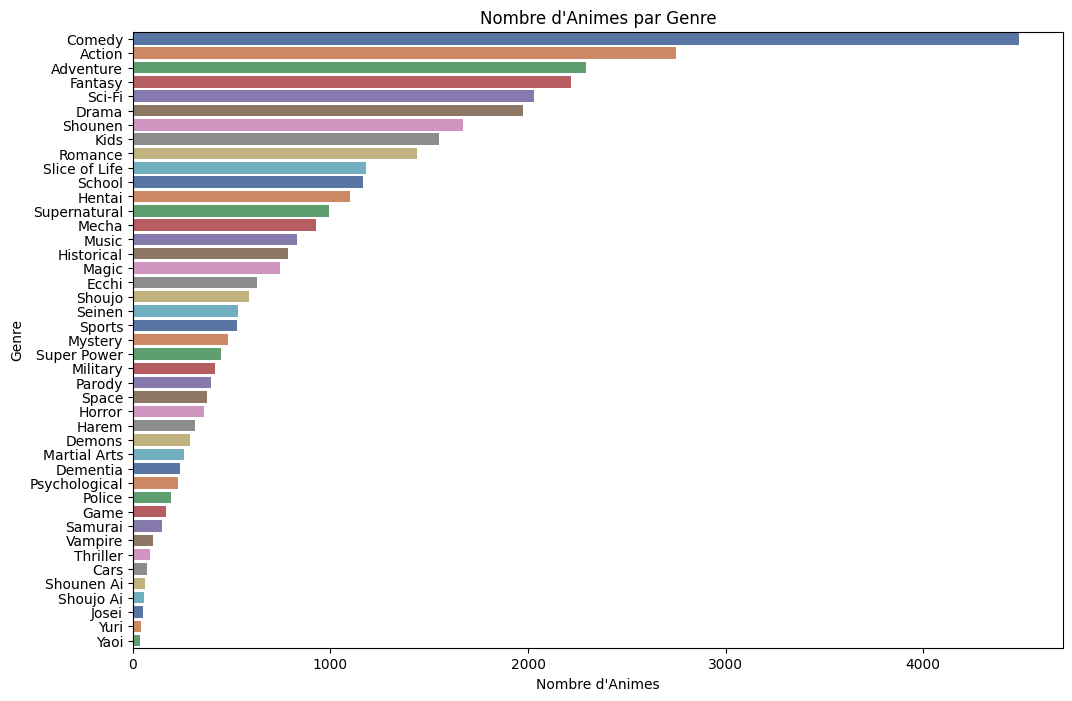

In [18]:
genre_counts = anime_genre_counts.reset_index()

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='count', y='unique_genre', data=genre_counts, ci=None, palette='deep')
plt.title('Nombre d\'Animes par Genre')
plt.xlabel('Nombre d\'Animes')
plt.ylabel('Genre')
plt.show()

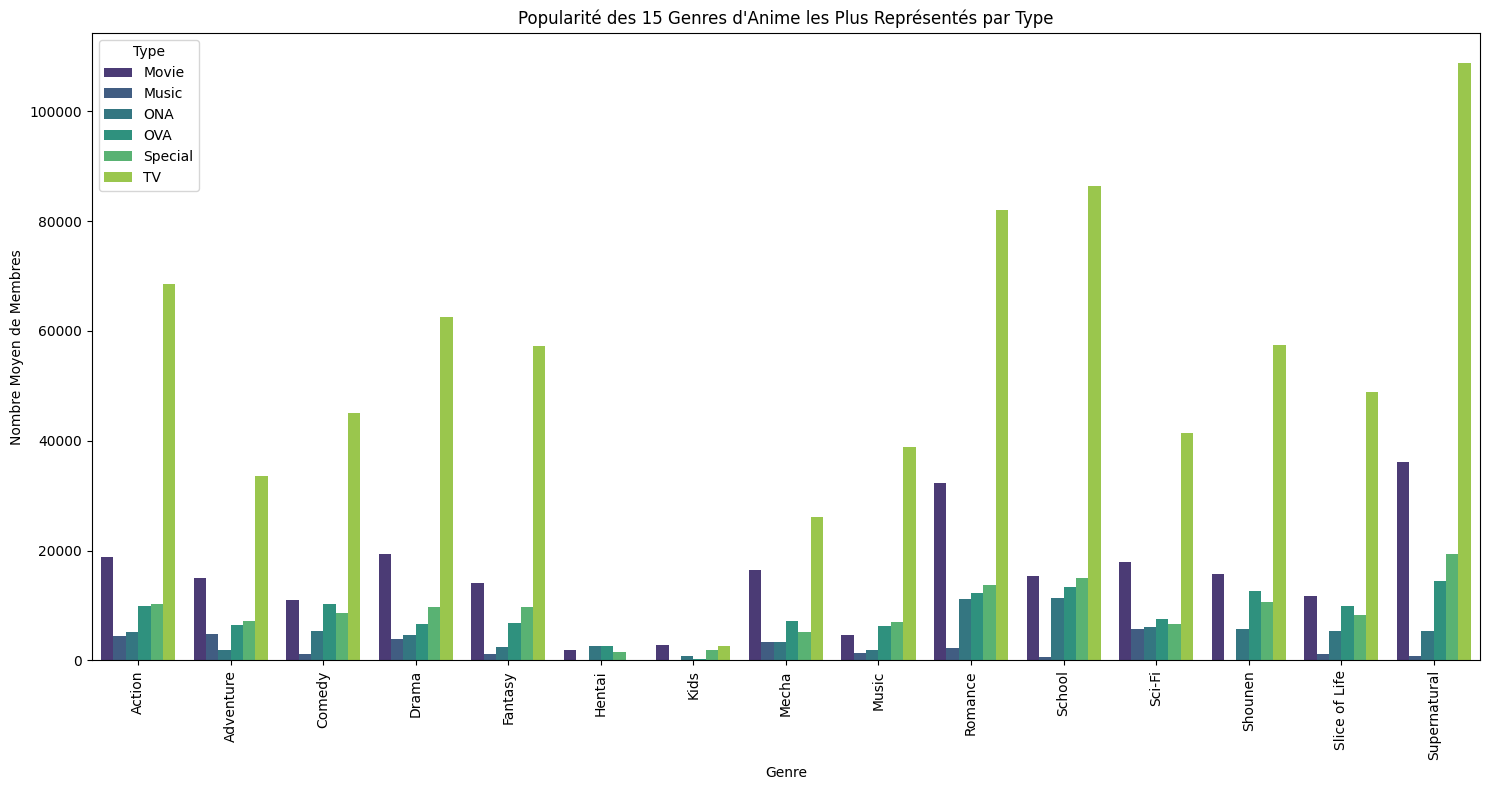

In [19]:
top_15_genres = exploded_genre_df['unique_genre'].value_counts().nlargest(15).index

filtered_data = exploded_genre_df[exploded_genre_df['unique_genre'].isin(top_15_genres)]

grouped_data = filtered_data.groupby(['unique_genre', 'type'])['members'].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=grouped_data, x='unique_genre', y='members', hue='type', palette='viridis')

plt.xticks(rotation=90)
plt.title('Popularité des 15 Genres d\'Anime les Plus Représentés par Type')
plt.xlabel('Genre')
plt.ylabel('Nombre Moyen de Membres')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

Ce résultat semble attendu.

Dans ce diagramme en batons regroupés pour deux variables (*genre* et *type*), nous remarquons que le type **TV** est le plus **représenté** par rapport aux autres types. Il est évidemment le plus abondant et le plus regardé. Dans une certaine mesure nous pourrions sciemment justifier cela par l'abondance du type **TV** grâce à son nombre d'épisodes, rendant le type chronophage. La plupart des oeuvres adaptées en anime retranscrivent toute la trame principale dans un format **TV** tandis que les **films d'animation** sont plus des add-on subsidiaires notamment les **OVA** réputés pour être regardés uniquement par les fans émérites de l'oeuvre principale.

S'ensuit donc juste après les **films d'animation** dont le nombre de visionnage est drastiquement moindre par rapport au type **TV** tout en restant bien plus constant et prononcé par rapport aux **OVA** et **ONA**. Certains **films d'animation** ne sont rattachés à aucun anime adapté en **TV** et se disent être des oeuvres originales non adaptées. On y dénombre principalement les films du studio *Ghibli* et toute une pléthore d'anime réalisés par M*akoto Shinkai*, *Mamoru Hosoda* ou encore (l'éminent) *Masaaki Yuasa*. D'autres **films d'animation** adaptant directement son manga d'origine sans passer par une adaptation **TV** existent bel et bien à l'instar du film *Akira*.
Les **OVA** et **Specials** sont des types considérés de "**niche**" étant donné qu'ils sont principalement regardées par les fans invétérés de l'anime. Les **ONA** sont bien moins populaires à cause de leur format de visionnage atypique oscillant entre 2 minutes et 40~50 minutes de durée par épisode. Il s'agit également d'un type d'anime dématérialisé disponible uniquement en ligne dans des sites de streaming gratuits ou payants. Ce qui justifie son manque de popularité et d'audience étant donné qu'ils ne sont diffusées nul part dans des chaines télévisées ou vendus en boite. Il est aussi à noter que le budget établi par les studios d'animation réalisant ce genre d'**ONA** demeure relativement réduit par rapport à la réalisation d'anime en format **TV** classique.

Une autre remarque éloquente serait de pointer du doigt la popularité de certains genres d'anime. Le genre *supernatural* semble bien prêter au jeu car il se trouve à l'intersection de d'autres genres similaires (*Action*, *Sci-Fi*, *Fantasy*). Le genre *School* se distingue raisonnablement des autres genres également. 
Le genre *Slice of Life* est assez représenté, il est généralement populaire quand il est couplé au genre *School*, marquant une grande audience de visionneurs ayant une tranche d'âge de lycéens. Le genre *Romance* est populaire étant donné qu'il peut être catégorisé avec d'autres genres (*Shojo*, *Josei*, *Comedy*, *School*).

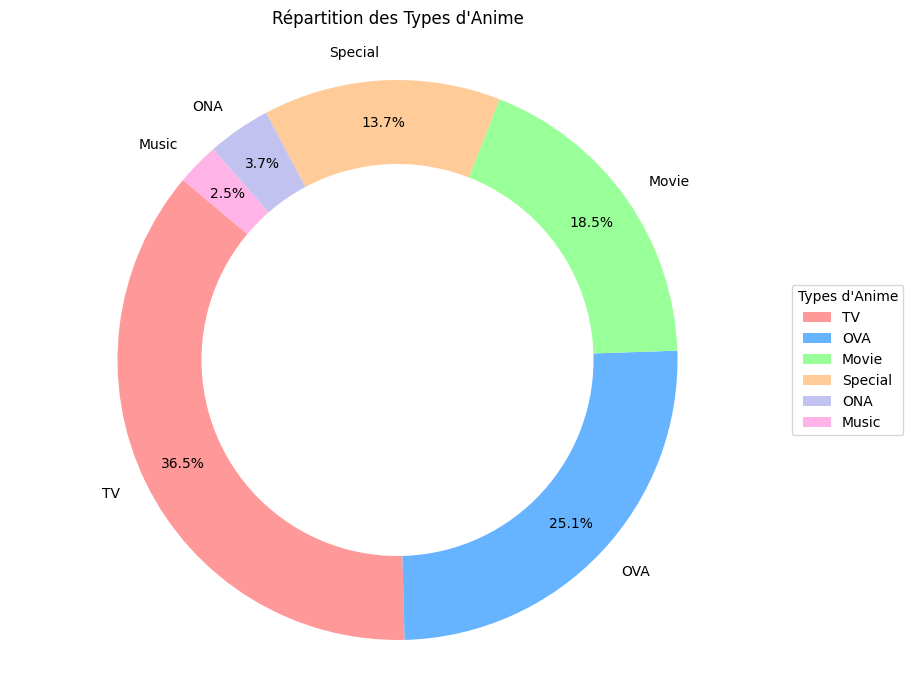

In [20]:
type_counts = exploded_genre_df['type'].value_counts()
labels = type_counts.index
sizes = type_counts.values

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0','#ffb3e6', '#c4e17f']

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.legend(labels, title="Types d'Anime", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Répartition des Types d\'Anime', pad=20)
plt.axis('equal')
plt.show()

### Tests paramétriques et non paramétriques 

Nous allons nous pencher sur l'usage de tests statistiques pour explorer davantage les dépendances d'ordre statistique qui existent entre nos variables explicatives. 

Nous tacherons de procéder par un premier test de significativité du coefficient de corrélation. Nous étudierons la relation entre deux variables quantitatives (la note moyenne et le nombre de visionnages).

**Est-ce que la note moyenne d'un anime est expliquée par sa popularité ?**

Pour ce faire nous allons représenter genre par genre en piochant sur les top 6 genres les plus visionnés le nuage de points ainsi que la droite de régression exprimée par la variable explicative (le nombre de visionnage) et la variable expliquée (la note moyenne). Puis nous calculerons le coefficient de corrélation défini comme suit :
$$r = \frac{\langle X - \bar{X}, Y - \bar{Y} \rangle}{\| X - \bar{X} \| \| Y - \bar{Y} \|}$$


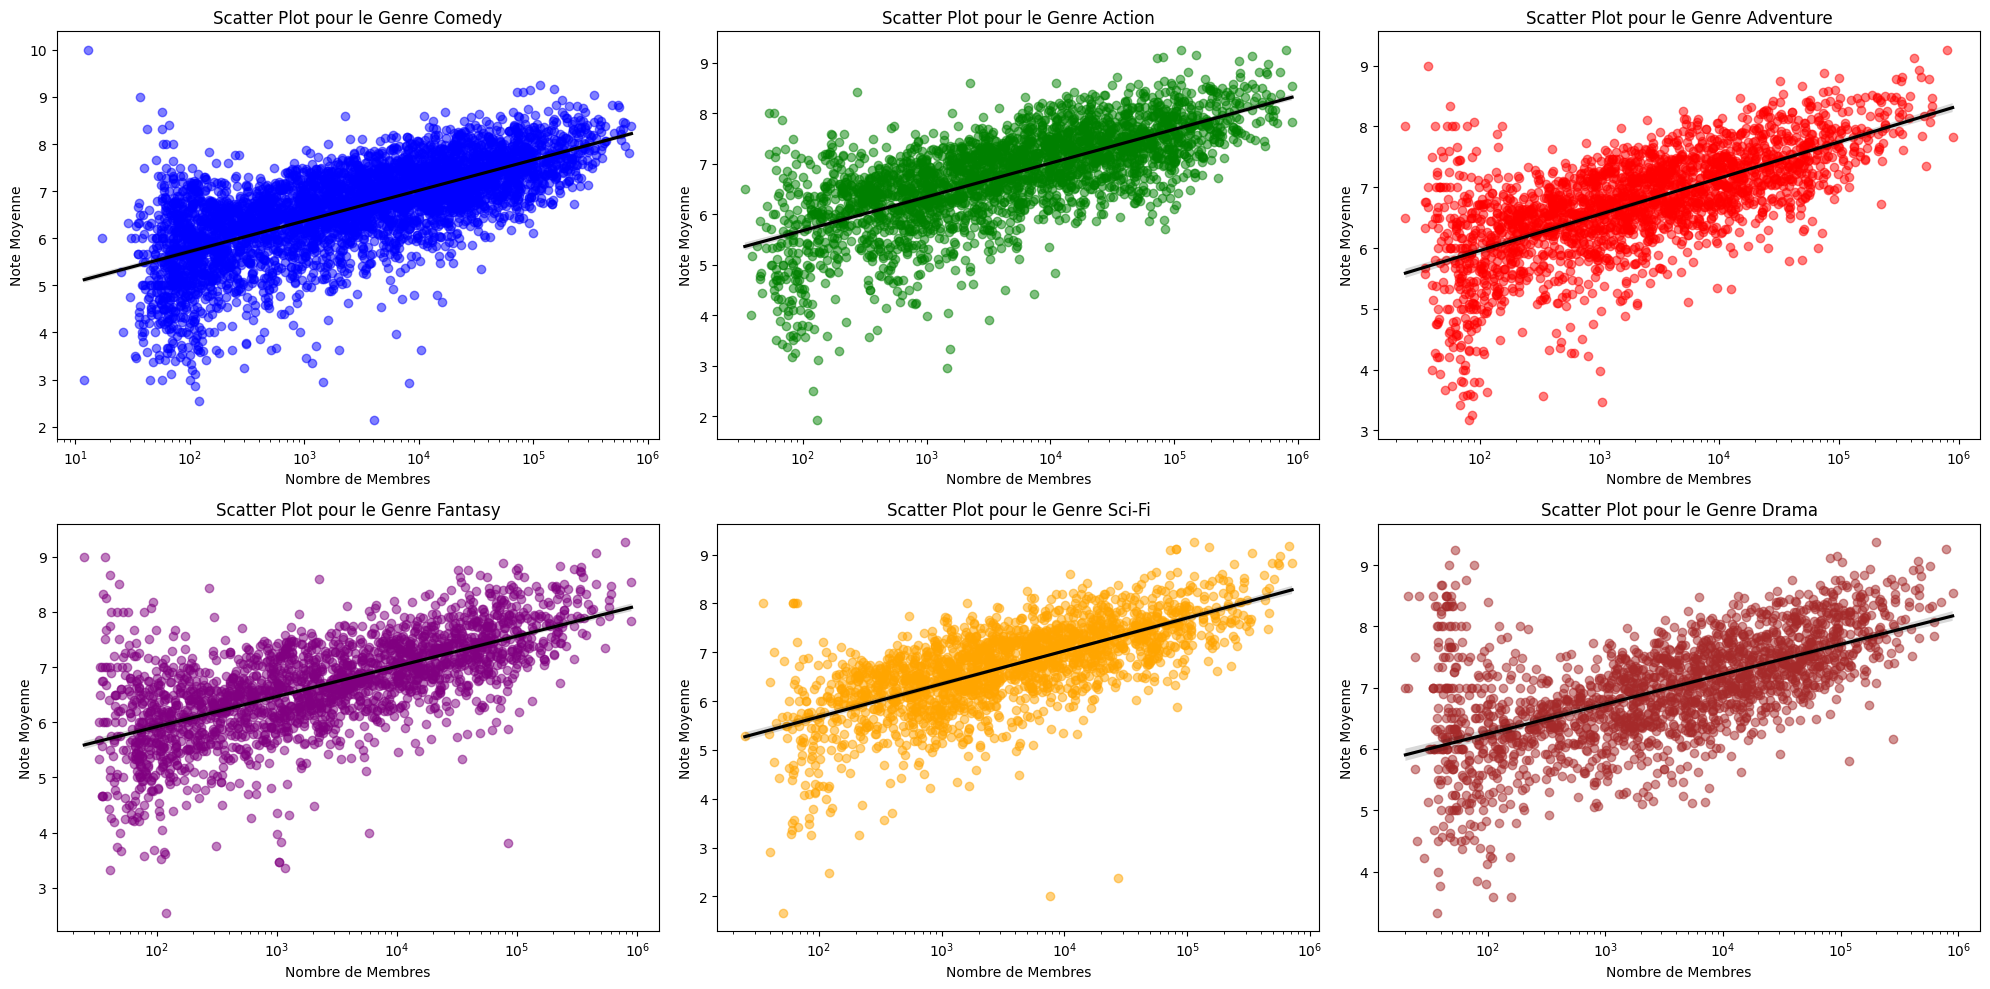

In [21]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

axes = axes.flatten()

top_genres = exploded_genre_df['unique_genre'].value_counts().nlargest(6).index.tolist()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

for i, genre in enumerate(top_genres):
    genre_df = exploded_genre_df[exploded_genre_df['unique_genre'] == genre]
    sns.regplot(ax=axes[i], data=genre_df, x='members', y='rating', 
                scatter_kws={'color': colors[i], 'alpha': 0.5},
                line_kws={'color': 'black'},
                logx=True)
    axes[i].set_title(f'Scatter Plot pour le Genre {genre}')
    axes[i].set_xlabel('Nombre de Membres')
    axes[i].set_ylabel('Note Moyenne')
    axes[i].set_xscale('log')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [22]:
columns_to_correlate = top_genres

correlation_with_rating = pd.DataFrame({
    'Genre': columns_to_correlate,
    'Correlation coefficient between the popularity and the rating': [
        pearsonr(exploded_genre_df[exploded_genre_df['unique_genre'] == genre]['members'],
                 exploded_genre_df[exploded_genre_df['unique_genre'] == genre]['rating'])[0]
        for genre in columns_to_correlate
    ]
})

correlation_with_rating_sorted = correlation_with_rating.sort_values(
    by='Correlation coefficient between the popularity and the rating',
    ascending=False
)

correlation_with_rating_sorted.reset_index(drop=True, inplace=True)
correlation_with_rating_sorted

,Genre,Correlation coefficient between the popularity and the rating
0,Drama,0.424566
1,Fantasy,0.420445
2,Action,0.417384
3,Sci-Fi,0.414145
4,Comedy,0.413826
5,Adventure,0.390236


Le coefficient de corrélation calculé n'arrive pas à expliquer suffisamment la variance des données. En moyenne 40% pour chaque genre visionné, ce qui reste faible.

Ce qui permet de conclure qu'il n'existe aucun lien entre la popularité d'un anime et sa note moyenne peu importe le genre choisi.

Pour explorer d'autres tests statistiques, nous allons opérer par un test d'adéquation à une loi donné à l'aide du test de *Kolmogorov-Smirnov* permettant de tracer les fonctions de répartition théoriques de chaque loi ainsi que la fonction de répartition empirique que suit la variable cible.

Visuellement, nous trancherons en prenant la fonction de répartition théorique qui épousera le mieux la forme de la fonction de répartition empirique.

SKIPPED gaussian distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,0.096026,743.939961,769.346450,inf,0.025133,9.493936e-20
dweibull,0.128443,740.804210,766.210699,inf,0.026818,1.993636e-22
norm,0.144145,889.505765,906.443424,inf,0.049458,2.869888e-75
f,0.151942,896.607136,930.482455,inf,0.050586,1.005179e-78
chi2,0.190113,946.615075,972.021564,inf,0.058736,5.274604e-106


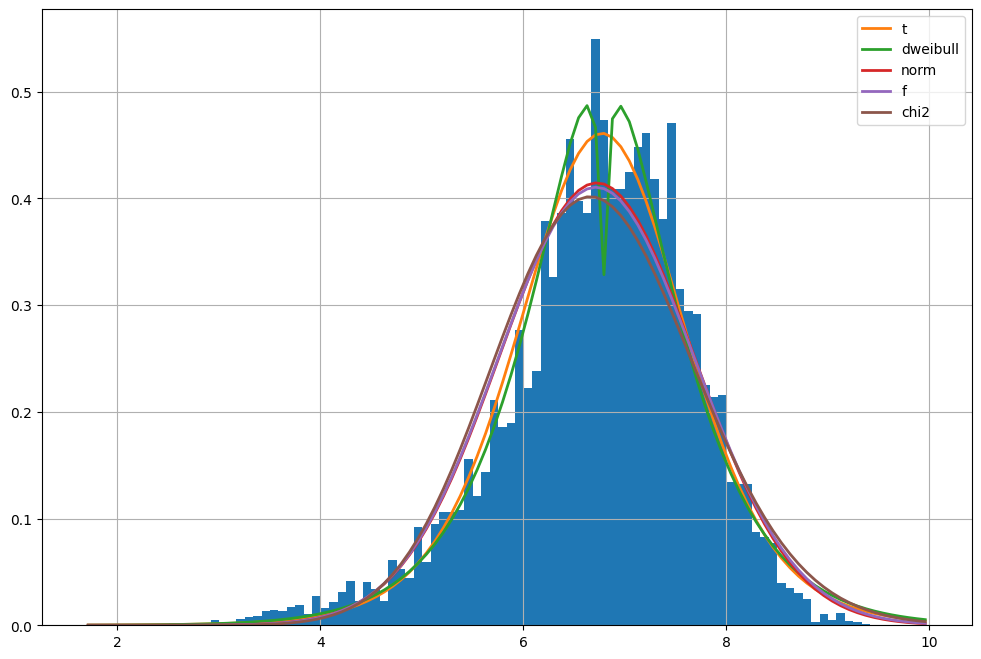

In [23]:
distribution_M2 = ["gaussian", "norm", "chi2", "cauchy", "expon", "f", "t", "gamma", "beta", "pareto", "uniform", "dweibull"]
f = Fitter(exploded_genre_df.rating, distributions=distribution_M2)
f.fit()

plt.figure(figsize=(12, 8))
plt.title('Distribution théorique et empirique des Notes')
f.summary()

SKIPPED gaussian distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,1.936622e-10,11913.210894,11947.086213,inf,0.166092,0.000000e+00
cauchy,4.509246e-10,3769.317282,3786.254941,inf,0.341729,0.000000e+00
pareto,1.166182e-09,3322.146524,3347.553014,inf,0.073853,2.045486e-167
expon,1.490588e-09,5740.361955,5757.299615,inf,0.396524,0.000000e+00
f,1.643469e-09,3304.937365,3338.812684,inf,0.097912,3.384151e-294


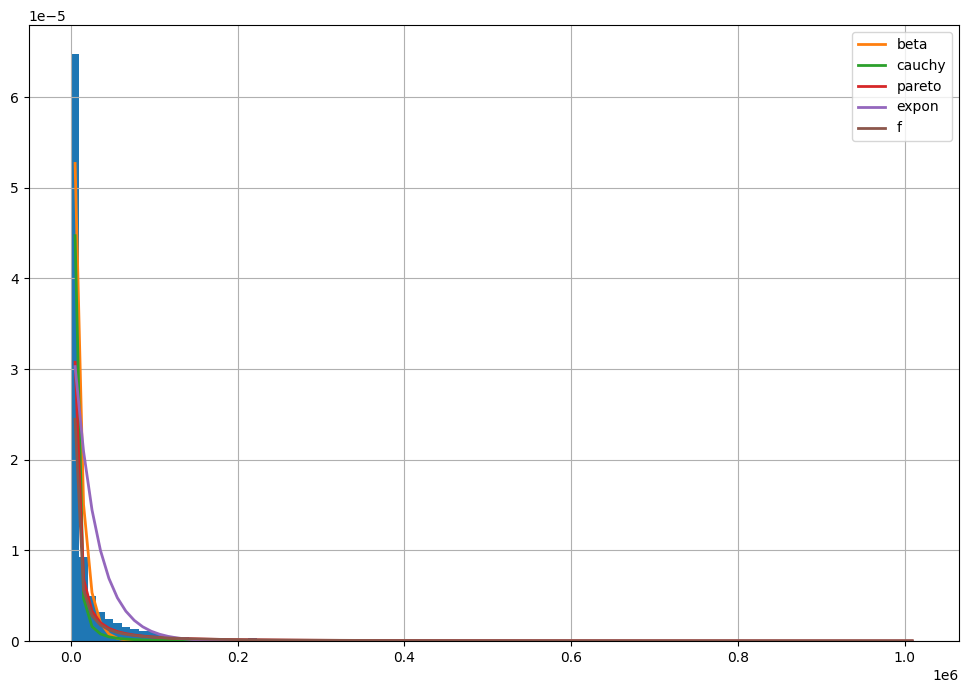

In [24]:
distribution_M2 = ["gaussian", "norm", "chi2", "cauchy", "expon", "f", "t", "gamma", "beta", "pareto", "uniform", "dweibull"]
f = Fitter(exploded_genre_df.members, distributions=distribution_M2)
f.fit()

plt.figure(figsize=(12, 8))
plt.title('Distribution théorique et empirique de la Popularité')
f.summary()

In [ ]:
Aucune des variables de la note m

In [25]:
unique_types = exploded_genre_df.type.unique().tolist()

genre_data = [exploded_genre_df[exploded_genre_df['unique_genre'] == anime_genre]['rating'] for anime_genre in top_genres]
type_data = [exploded_genre_df[exploded_genre_df['type'] == anime_type]['rating'] for anime_type in unique_types]

genre_stat, genre_p_value = kruskal(*genre_data)
type_stat, type_p_value = kruskal(*type_data)

kruskal_results = pd.DataFrame({
    'Variable': ['genre', 'type'],
    'Statistic': [genre_stat, type_stat],
    'p-value': [genre_p_value, type_p_value],
    'Rejection': [genre_p_value < .05, type_p_value < .05]
})

kruskal_results

,Variable,Statistic,p-value,Rejection
0,genre,188.956038,6.530619e-39,True
1,type,4146.438120,0.000000e+00,True


# Rating Dataset
## Importation et description des données

In [26]:
rating_df = pd.read_csv(r'../data/rating.csv')
rating_df.head(20)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


In [27]:
rating_df.shape

(7813737, 3)

In [28]:
rating_df.columns.tolist()

['user_id', 'anime_id', 'rating']

In [29]:
rating_df.dtypes


user_id     int64
anime_id    int64
rating      int64
dtype: object

In [30]:
missing_rate = pd.DataFrame({
                             'count': (rating_df.isna().sum()),
                             'rate': (rating_df.isna().sum() * 100 / rating_df.shape[0]) 
                            }).sort_values(by = 'rate', ascending = False)
missing_rate

,count,rate
user_id,0,0.0
anime_id,0,0.0
rating,0,0.0


In [31]:
total_animes_par_user = rating_df[rating_df["rating"] != -1].groupby("user_id")["anime_id"].count()

mean = total_animes_par_user.mean()
median = total_animes_par_user.median()
interquartile_range = total_animes_par_user.quantile(0.75) - total_animes_par_user.quantile(0.25)
kurtosis = total_animes_par_user.kurtosis()
flattening_coefficient = 3 - (6 / (total_animes_par_user.std() / total_animes_par_user.mean()))
dispersion_mean = total_animes_par_user.std() / total_animes_par_user.mean() * 100
dispersion_median = interquartile_range / median * 100

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
quantiles_values = total_animes_par_user.quantile(quantiles)

statistics_watching_df = pd.DataFrame(
    {
        'Total des Anime vus par les Utilisateurs': [mean, median, interquartile_range, kurtosis, flattening_coefficient, dispersion_mean, dispersion_median]
                + quantiles_values.tolist()
    },
    index=['Mean' ,'Median', 'Interquartile Range', 'Kurtosis', 'Flattening Coefficient', 'Dispersion based on Mean',
           'Dispersion based on Median'] + [f'Quantile {int(q * 100)}%' for q in quantiles]
)

statistics_watching_df

,Total des Anime vus par les Utilisateurs
Mean,91.052313
Median,45.000000
Interquartile Range,101.000000
Kurtosis,40.570747
Flattening Coefficient,-1.023989
Dispersion based on Mean,149.105770
Dispersion based on Median,224.444444
Quantile 5%,2.000000
Quantile 25%,13.000000
Quantile 50%,45.000000


In [32]:
rating_df_noted = rating_df[rating_df["rating"] != -1]
anime_df.rename(columns={'rating': 'rating_mean'}, inplace=True)

anime_rating_df = pd.merge(rating_df_noted, anime_df, on='anime_id')

In [33]:
anime_rating_df

,user_id,anime_id,rating,name,genre,type,episodes,rating_mean,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
...,...,...,...,...,...,...,...,...,...
6337139,69964,23585,7,Haha wo Tazunete Sanzenri Specials,"Adventure, Drama, Slice of Life",Special,2,6.14,138
6337140,69964,33659,6,Fushigi na Somera-chan Special,"Comedy, Magic, Slice of Life",Special,1,5.15,444
6337141,72800,30738,4,Gamba: Gamba to Nakama-tachi,"Adventure, Kids",Movie,1,5.55,185
6337142,73135,8723,5,Anime Rakugo Kan,Comedy,OVA,4,5.84,264


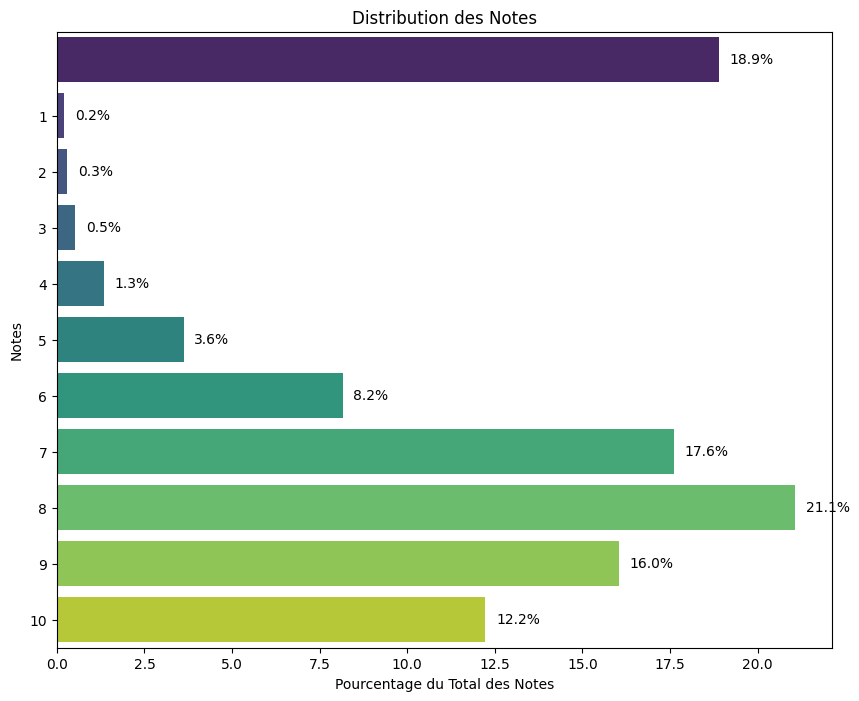

In [34]:
rating_counts = rating_df['rating'].value_counts()
total = rating_counts.sum()
percentages = (rating_counts / total) * 100
sorted_percentages = percentages.sort_index()

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=sorted_percentages.values, y=sorted_percentages.index, orient='h', palette='viridis')

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.3, p.get_y() + p.get_height() / 2, f'{width:.1f}%', va='center')

plt.title("Distribution des Notes")
plt.xlabel("Pourcentage du Total des Notes")
plt.ylabel("Notes")
plt.yticks(range(1, 11))
plt.show()

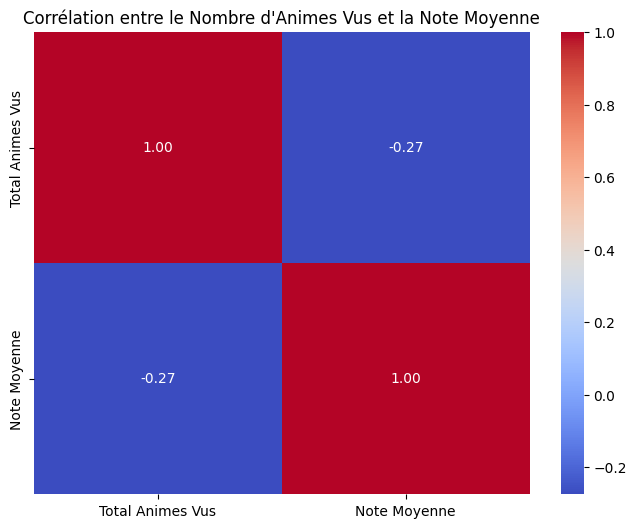

In [35]:
user_anime_counts = rating_df.groupby('user_id')['anime_id'].count()
user_rating_means = rating_df[rating_df['rating'] > 0].groupby('user_id')['rating'].mean()

user_data = pd.DataFrame({
    'Total Animes Vus': user_anime_counts,
    'Note Moyenne': user_rating_means
}).dropna()

corr_matrix = user_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre le Nombre d'Animes Vus et la Note Moyenne")
plt.show()

In [36]:
columns_to_correlate = ['Total Animes Vus', 'Note Moyenne']

corr, p_value = pearsonr(user_data['Total Animes Vus'], user_data['Note Moyenne'])

correlation_result = pd.DataFrame({
    'Variables': ['Total Animes Vus vs Note Moyenne'],
    'Correlation Coefficient': [corr],
    'p-value': [p_value]
})

correlation_result

,Variables,Correlation Coefficient,p-value
0,Total Animes Vus vs Note Moyenne,-0.274915,0.0


In [37]:
def calculate_rating_threshold(rating_df, column_name='rating', quantile_high=0.75, quantile_low=0.25):
    """
    Calcule un seuil de notation en se basant sur des mesures statistiques.
    
    Args:
    - rating_df (pd.DataFrame): DataFrame contenant les notes.
    - column_name (str): Nom de la colonne contenant les notes.
    - quantile_high (float): Quantile supérieur pour définir les notes élevées.
    - quantile_low (float): Quantile inférieur pour définir les notes basses.

    Returns:
    - float: Seuil de notation calculé.
    """
    user_rating_counts = rating_df.groupby('user_id')[column_name].count()

    high_count_threshold = user_rating_counts.quantile(quantile_high)
    low_count_threshold = user_rating_counts.quantile(quantile_low)

    users_high = user_rating_counts[user_rating_counts >= high_count_threshold].index
    users_low = user_rating_counts[user_rating_counts <= low_count_threshold].index

    high_avg_rating = rating_df[rating_df['user_id'].isin(users_high)][column_name].mean()
    low_avg_rating = rating_df[rating_df['user_id'].isin(users_low)][column_name].mean()

    rating_threshold = np.mean([high_avg_rating, low_avg_rating])
    return rating_threshold

threshold = calculate_rating_threshold(rating_df)
print("Calculated Rating Threshold:", threshold)


Calculated Rating Threshold: 6.599470113744922


In [38]:
anime_rating_df

,user_id,anime_id,rating,name,genre,type,episodes,rating_mean,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
...,...,...,...,...,...,...,...,...,...
6337139,69964,23585,7,Haha wo Tazunete Sanzenri Specials,"Adventure, Drama, Slice of Life",Special,2,6.14,138
6337140,69964,33659,6,Fushigi na Somera-chan Special,"Comedy, Magic, Slice of Life",Special,1,5.15,444
6337141,72800,30738,4,Gamba: Gamba to Nakama-tachi,"Adventure, Kids",Movie,1,5.55,185
6337142,73135,8723,5,Anime Rakugo Kan,Comedy,OVA,4,5.84,264


In [39]:
def classify_users(rating_df, user_thresholds={'low': 0.25, 'medium': 0.50, 'high': 0.75, 'very_high': 0.90}):
    """
    Classifie les utilisateurs en fonction du nombre de leurs évaluations et d'un seuil de notation spécifié.

    Cette fonction regroupe les utilisateurs en catégories basées sur le nombre de notes qu'ils ont données.
    Elle utilise des seuils de quantiles pour définir ces catégories. De plus, les utilisateurs qui donnent
    fréquemment des notes en dessous d'un certain seuil sont classés comme 'Otaku'.

    Arguments :
    - rating_df (pd.DataFrame) : Un DataFrame pandas contenant au moins deux colonnes : 'user_id' et 'rating'.
    - user_thresholds (dict, optionnel) : Un dictionnaire spécifiant les seuils de quantile pour différentes catégories d'utilisateurs.
                                          Par défaut : {'low': 0.25, 'medium': 0.50, 'high': 0.75, 'very_high': 0.90}.
    - rating_threshold (float, optionnel) : Le seuil pour classer les utilisateurs comme 'Otaku' en fonction de leur note moyenne.
                                            Si None, ce seuil est calculé en utilisant la fonction calculate_rating_threshold.
    
    Retourne :
    - pd.DataFrame : Le DataFrame original avec une colonne supplémentaire 'category', qui contient la catégorie de chaque utilisateur.
    """
    user_stats = rating_df.groupby('user_id')['rating'].agg(['count', 'mean', 'std']).reset_index()

    low_count_threshold = user_stats['count'].quantile(user_thresholds['low'])
    medium_count_threshold = user_stats['count'].quantile(user_thresholds['medium'])
    high_count_threshold = user_stats['count'].quantile(user_thresholds['high'])
    very_high_count_threshold = user_stats['count'].quantile(user_thresholds['very_high'])

    bins = [0, low_count_threshold, medium_count_threshold, high_count_threshold, very_high_count_threshold, float('inf')]
    labels = ['Newfag', 'Casual', 'Oldfag', 'Otaku', 'Tastelet']
    user_stats['category'] = pd.cut(user_stats['count'], bins=bins, labels=labels, right=False)

    
    rating_df = rating_df.merge(user_stats[['user_id', 'category']], on='user_id', how='left')

    return rating_df

rating_df_noted = classify_users(rating_df_noted)



In [41]:
def set_elitist_user_category(rating_df, rating_threshold):
    """
    Ajuste la catégorie des utilisateurs dans le DataFrame selon que leur note moyenne est inférieure au seuil donné
    et qu'ils sont déjà classés comme 'Tastelet' ou 'Otaku'.
    """
    user_average = rating_df.groupby('user_id')['rating'].mean().reset_index(name='average_rating')
    rating_df = rating_df.merge(user_average, on='user_id', how='left')

    if 'Elitist' not in rating_df['category'].cat.categories:
        rating_df['category'] = rating_df['category'].cat.add_categories(['Elitist'])

    rating_df.loc[(rating_df['category'].isin(['Tastelet', 'Otaku'])) & (rating_df['average_rating'] < rating_threshold), 'category'] = 'Elitist'
    return rating_df


In [42]:
rating_df_noted = set_elitist_user_category(rating_df_noted, calculate_rating_threshold(rating_df))

In [138]:
rating_df_noted[rating_df_noted['category'] == "Elitist"]

,user_id,anime_id,rating,category,average_rating
97,5,6,8,Elitist,4.355120
98,5,15,6,Elitist,4.355120
99,5,17,6,Elitist,4.355120
100,5,18,6,Elitist,4.355120
101,5,20,6,Elitist,4.355120
...,...,...,...,...,...
6336469,73503,32379,7,Elitist,6.418699
6336470,73503,32438,6,Elitist,6.418699
6336471,73503,32595,3,Elitist,6.418699
6336472,73503,32608,4,Elitist,6.418699


In [43]:
rating_df_noted

,user_id,anime_id,rating,category,average_rating
0,1,8074,10,Newfag,10.000000
1,1,11617,10,Newfag,10.000000
2,1,11757,10,Newfag,10.000000
3,1,15451,10,Newfag,10.000000
4,2,11771,10,Newfag,10.000000
...,...,...,...,...,...
6337236,73515,16512,7,Otaku,8.547486
6337237,73515,17187,9,Otaku,8.547486
6337238,73515,22145,10,Otaku,8.547486
6337239,73516,790,9,Newfag,9.000000


### Détection des anomalies (notes anormalement trop hautes ou basses)

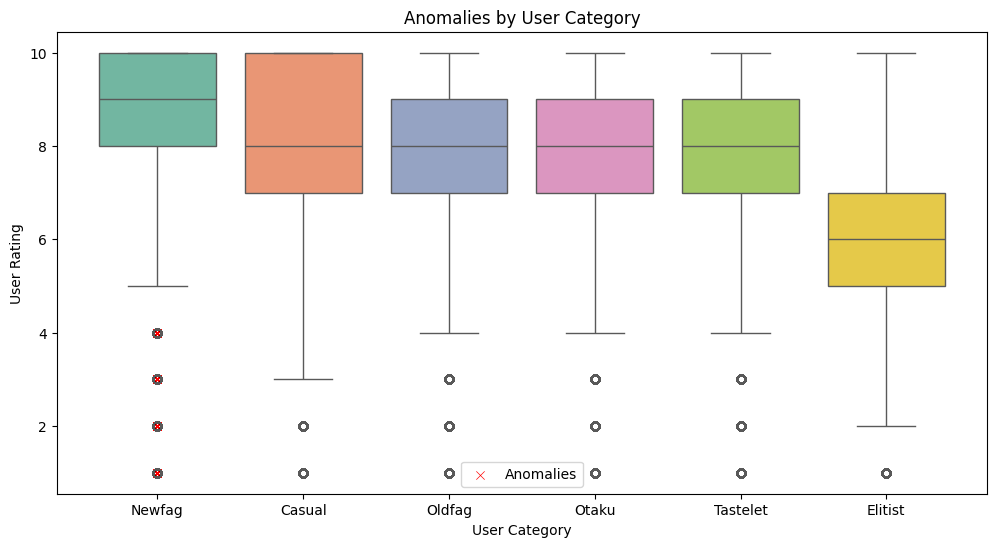

,user_id,anime_id,rating,category,average_rating,anomaly_type
0,143,747,4,Newfag,5.333333,Low
1,162,9310,4,Newfag,4.500000,Low
2,205,3455,4,Newfag,6.666667,Low
3,205,9181,4,Newfag,6.666667,Low
4,205,13663,4,Newfag,6.666667,Low
...,...,...,...,...,...,...
1056,73307,11887,1,Newfag,4.750000,Low
1057,73307,18245,1,Newfag,4.750000,Low
1058,73350,788,1,Newfag,1.000000,Low
1059,73381,15605,2,Newfag,8.142857,Low


In [44]:

def detect_anomalies_by_user_category(rating_df, user_category_column='category', rating_column='rating'):
    """
    Détecte les notes anormalement hautes et basses pour chaque catégorie d'utilisateurs.

    Arguments :
    - rating_df (pd.DataFrame) : DataFrame contenant les notes et les catégories d'utilisateurs.
    - user_category_column (str) : Nom de la colonne dans le DataFrame qui contient les catégories d'utilisateurs.
    - rating_column (str) : Nom de la colonne dans le DataFrame qui contient les notes des utilisateurs.

    Retourne :
    - pd.DataFrame : DataFrame contenant les anomalies détectées avec des informations supplémentaires.
    """
    anomalies = pd.DataFrame()

    for category in rating_df[user_category_column].unique():
        category_df = rating_df[rating_df[user_category_column] == category]
        
        Q1 = category_df[rating_column].quantile(0.25)
        Q3 = category_df[rating_column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        category_anomalies = category_df[(category_df[rating_column] < lower_bound) | (category_df[rating_column] > upper_bound)].copy()
        category_anomalies['anomaly_type'] = np.where(category_anomalies[rating_column] < lower_bound, 'Low', 'High')
        category_anomalies['category'] = category

        anomalies = pd.concat([anomalies, category_anomalies], ignore_index=True)

        plt.figure(figsize=(12, 6))
        sns.boxplot(x=user_category_column, y=rating_column, data=rating_df, palette="Set2")
        sns.scatterplot(x=user_category_column, y=rating_column, data=anomalies,
                        color='red', label='Anomalies', marker='x')

        plt.title('Anomalies by User Category')
        plt.xlabel('User Category')
        plt.ylabel('User Rating')
        plt.legend()
        plt.show()

        return anomalies

anomalies_df = detect_anomalies_by_user_category(rating_df_noted)
anomalies_df

# Collaborative filtering 

## Création de modèles de système de recommandation

In [359]:
def load_data_from_csv(rating_df, strate):
    rating_df_stratified = rating_df[["user_id", "anime_id", "rating"]][rating_df["category"] == strate]

    reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 10))
    rating_data = Dataset.load_from_df(rating_df_stratified, reader=reader)
    rating_data.df['rating'] = rating_data.df['rating'].astype(np.float32)
    
    return rating_data


def train_and_predict_with_best_params_loo(algo_class, rating_data, user_id, param_grid=None, cv=2, joblib_verbose=0):
    """
    Entraîne un modèle de recommandation en utilisant GridSearchCV pour trouver les meilleurs hyperparamètres,
    puis fait des prédictions en utilisant une validation croisée Leave-One-Out.
    """
    if param_grid is not None and len(param_grid) > 0:
        gs = GridSearchCV(algo_class, param_grid, measures=['rmse', 'mae'], cv=cv, joblib_verbose=joblib_verbose)
        gs.fit(rating_data)

        best_params = gs.best_params['rmse']
        print("Meilleurs hyperparamètres trouvés:", best_params)

        best_model = algo_class(**best_params)
    else:
        best_model = algo_class()
        
    loo = LeaveOneOut(n_splits=1, random_state=777)

    for train_set, test_set in loo.split(rating_data):
        best_model.fit(train_set)

        anti_testset = train_set.build_anti_testset(fill=train_set.global_mean)
        user_anti_testset = filter(lambda x: x[0] == user_id, anti_testset)
        predictions = best_model.test(user_anti_testset)
        break

    return best_model, train_set, test_set, predictions

def save_model_to_pickle(model, user_id, file_name):
    """
    Sauvegarde un modèle dans un fichier pickle.
    Cette fonction crée un fichier pickle dans un emplacement spécifié, en utilisant l'ID utilisateur 
    et le nom de fichier donnés. 
    """
    file_path_components = ['../models', str(user_id)] + file_name.split('/')
    full_file_path = os.path.join(*file_path_components)
    os.makedirs(os.path.dirname(full_file_path), exist_ok=True)

    with open(full_file_path, 'wb') as f:
        pickle.dump(model, f)

def load_model_from_pickle(user_id, file_name):
    """
    Charge un modèle depuis un fichier pickle.
    Ouvre et charge le modèle stocké dans un fichier pickle spécifié, en utilisant l'ID utilisateur 
    et le nom de fichier fournis.
    """
    with open(f'../models/{user_id}/{file_name}', 'rb') as f:
        model = pickle.load(f)
    return model

In [49]:
def get_top_n(predictions, n=10):
    """Retourne les meilleures n recommandations pour chaque utilisateur depuis un ensemble de prédictions."""
    top_n = defaultdict(list)
    for uid, iid, true_r, est, *_ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def hit_rate(top_n, left_out_predictions):
    """Calculer le Hit Rate."""
    hits = 0
    total = 0

    for left_out in left_out_predictions:
        uid = left_out[0]
        left_out_iid = left_out[1]
        hit = next((True for iid, _ in top_n.get(uid, []) if iid == left_out_iid), False)
        if hit:
            hits += 1
        total += 1

    hit_rate = hits / total if total > 0 else 0
    return hit_rate

def cumulative_hit_rate(top_n, left_out_predictions, rating_cutoff=4.0):
    """Calculer le Cumulative Hit Rate avec un seuil de notation."""
    hits = 0
    total = 0

    for uid, _, true_r in left_out_predictions:
        if true_r >= rating_cutoff:
            hit = next((True for iid, est in top_n.get(uid, []) if est >= rating_cutoff), False)
            if hit:
                hits += 1
            total += 1

    return hits / total if total > 0 else 0


def average_reciprocal_hit_rank(top_n, left_out_predictions):
    """Calculer l'Average Reciprocal Hit Rank."""
    summation = 0
    total = 0

    for uid, left_out_iid, _ in left_out_predictions:  
        hit_rank = next((rank for rank, (iid, _) in enumerate(top_n.get(uid, []), start=1) if iid == left_out_iid), None)
        if hit_rank:
            summation += 1.0 / hit_rank
        total += 1

    return summation / total if total > 0 else 0

def user_coverage(top_n, threshold=4.0):
    """
    Calcule la couverture des utilisateurs, définie comme la proportion d'utilisateurs pour lesquels
    le système peut faire au moins une recommandation au-dessus d'un certain seuil.
    """
    relevant_users = sum(any(est >= threshold for _, est in recommendations) for recommendations in top_n.values())
    total_users = len(top_n)

    return relevant_users / total_users if total_users > 0 else 0


In [108]:
def calculate_and_display_score_metrics(predictions, leave_one_out_test):
    """
    Calcule et retourne les scores des métriques de performance pour le système de recommandation.
    """
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)

    top_n = get_top_n(predictions)
    hit_rate_value = hit_rate(top_n, leave_one_out_test)
    cumulative_hit_rate_value = cumulative_hit_rate(top_n, leave_one_out_test, rating_cutoff=4.0)
    arhr = average_reciprocal_hit_rank(top_n, leave_one_out_test)
    user_coverage_value = user_coverage(top_n, threshold=4.0)

    metrics_dict = {
        "RMSE": rmse,
        "MAE": mae,
        "Hit Rate": hit_rate_value,
        "Cumulative Hit Rate": cumulative_hit_rate_value,
        "Average Reciprocal Hit Rank": arhr,
        "User Coverage": user_coverage_value
    }
    
    return metrics_dict


def add_model_metrics_to_df(model_name, metrics_dict, df_results):
    """
    Ajoute les métriques d'un modèle de système de recommandation à un DataFrame pandas,
    avec le nom du modèle comme indice.
    """
    df_results.loc[model_name] = metrics_dict.values()
    return df_results

In [51]:
results_df = pd.DataFrame(columns=["RMSE", "MAE", "Hit Rate", "Cumulative Hit Rate", "Average Reciprocal Hit Rank", "User Coverage"])

In [52]:
rating_data = load_data_from_csv(rating_df_noted, "Otaku")

## User based filtering

#### KNN Basic

In [175]:
param_grid = {
    'sim_options': {
        'name': ['cosine', 'pearson', 'pearson_baseline', 'msd'],
        'user_based': [True],
    },
    'k': [10],
}

In [176]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=KNNBasic, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed: 93.3min


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Meilleurs hyperparamètres trouvés: {'sim_options': {'name': 'msd', 'user_based': True}, 'k': 10}
Computing the msd similarity matrix...
Done computing similarity matrix.


In [177]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 1.234313304774675,
 'MAE': 0.8656136831006398,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [178]:
model_metrics = add_model_metrics_to_df("KNNBasic user based", metrics_scores, results_df)

In [179]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/user-based/KNNBasicUser.pkl')

#### KNNWithMeans

In [180]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=KNNWithMeans, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed: 94.5min


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Meilleurs hyperparamètres trouvés: {'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'k': 10}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [181]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 1.0313272950306078,
 'MAE': 0.7675313189079538,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [182]:
model_metrics = add_model_metrics_to_df("KNNBasic user based", metrics_scores, results_df)

In [183]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/user-based/KNNWithMeansUser.pkl')

#### KNNWithZScore

In [184]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=KNNWithZScore, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed: 93.2min


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Meilleurs hyperparamètres trouvés: {'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'k': 10}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [185]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 0.8391961931499405,
 'MAE': 0.6484970291380486,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [186]:
model_metrics = add_model_metrics_to_df("KNNWithZScore user based", metrics_scores, results_df)

In [187]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/user-based/KNNWithZScoreUser.pkl')

#### KNNBaseline

In [188]:
param_grid = {
                "sim_options": {
                                "name": ["cosine", "msd", "pearson_baseline"],
                                "user_based" : [True],
                                },
                "bsl_options" : {
                                "method": ["als"],
                                "n_epochs": [5],
                                "reg_u": [10],
                                "reg_i": [10]
                              },
                "min_k": list(range(5,10)),
             }

In [189]:
best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=KNNBaseline, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed: 90.2min


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 350.0min


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Meilleurs hyperparamètres trouvés: {'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'bsl_options': {'method': 'als', 'n_epochs': 5, 'reg_u': 10, 'reg_i': 10}, 'min_k': 8}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [190]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 0.6474380093321938,
 'MAE': 0.5097619590837101,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [191]:
model_metrics = add_model_metrics_to_df("KNNBaseline user based", metrics_scores, results_df)

In [192]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/user-based/KNNBaselineUser.pkl')

## Item based filtering

#### KNN Basic

In [193]:
param_grid = {
    'sim_options': {
        'name': ['cosine', 'pearson', 'pearson_baseline', 'msd'],
        'user_based': [False],
    },
    'k': [10],
}

In [67]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=KNNBasic, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed: 14.6min


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Meilleurs hyperparamètres trouvés: {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'k': 10}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [69]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 0.9044757431739044,
 'MAE': 0.7516354987042413,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [70]:
model_metrics = add_model_metrics_to_df("KNNBasic item based", metrics_scores, results_df)

In [74]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/item-based/KNNBasicItem.pkl')

#### KNNWithMeans

In [194]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=KNNWithMeans, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  9.2min


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Meilleurs hyperparamètres trouvés: {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'k': 10}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [195]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 1.1580123472466328,
 'MAE': 0.8268657020415084,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [196]:
model_metrics = add_model_metrics_to_df("KNNWithMeans item based", metrics_scores, results_df)

In [197]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/item-based/KNNWithMeansItem.pkl')

#### KNNWithZScore

In [198]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=KNNWithZScore, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  9.4min


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Meilleurs hyperparamètres trouvés: {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'k': 10}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [199]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 1.1453499198947001,
 'MAE': 0.8184057894331634,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [200]:
model_metrics = add_model_metrics_to_df("KNNWithZScore item based", metrics_scores, results_df)

In [201]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/item-based/KNNWithZScoreItem.pkl')


#### KNNBaseline

In [202]:
param_grid = {
                "sim_options": {
                                "name": ["cosine", "msd", "pearson_baseline"],
                                "user_based" : [False],
                                },
                "bsl_options" : {
                                "method": ["als"],
                                "n_epochs": [5],
                                "reg_u": [10],
                                "reg_i": [10]
                              },
                "min_k": list(range(5,10)),
             }

In [203]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=KNNBaseline, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed: 11.4min


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 45.2min


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Meilleurs hyperparamètres trouvés: {'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'bsl_options': {'method': 'als', 'n_epochs': 5, 'reg_u': 10, 'reg_i': 10}, 'min_k': 9}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [204]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 0.6047066108432319,
 'MAE': 0.486618426452279,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [205]:
model_metrics = add_model_metrics_to_df("KNNBaseline item based", metrics_scores, results_df)

In [206]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/item-based/KNNBaselineItem.pkl')


## Matrix Factorization (MF)
#### Décomposition en valeurs singulières (SVD)
##### Sans feedback implicites

In [143]:
param_grid = {
              'n_factors': [50, 75],
              'n_epochs': [5, 10],
              'lr_all': [0,1, 0.01, 0.001],
              'reg_all': [0.02]
             }

In [144]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=SVD, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  9.7min


Meilleurs hyperparamètres trouvés: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.02}


In [145]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 0.5978727405341242,
 'MAE': 0.46766937196060143,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [353]:
model_metrics = add_model_metrics_to_df("SVD Without Implicit Feedback", metrics_scores, results_df)

In [147]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/factorization-matrix/SVDWithoutImplicitFeedback.pkl')


##### Avec feedback implicites

In [ ]:
param_grid = {
              'n_factors': [50, 75],
              'n_epochs': [5, 10],
              'lr_all': [0,1, 0.01],
              'reg_all': [0.02]
             }

In [149]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=SVDpp, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed: 54.6min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 472.1min


Meilleurs hyperparamètres trouvés: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.02}


In [150]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 0.5844341494141629,
 'MAE': 0.46168140369075455,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [151]:
model_metrics = add_model_metrics_to_df("SVD With Implicit Feedback", metrics_scores, results_df)

In [152]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/factorization-matrix/SVDWithImplicitFeedback.pkl')


#### Non-negative Matrix Factorization (NMF)

In [155]:
param_grid = {
    'n_factors': [50, 70],
    'n_epochs': [5, 10],
    'lr_bu': [0.01],
    'lr_bi': [0.01],
    'reg_pu': [0.02, 0.05],
    'reg_qi': [0.02, 0.05],
    'reg_bu': [0.02, 0.05],
    'reg_bi': [0.02, 0.05]
}


In [162]:
best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=NMF, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 12.6min
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed: 29.5min
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed: 45.2min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed: 84.6min
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed: 139.5min
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed: 167.5min
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed: 195.7min


Meilleurs hyperparamètres trouvés: {'n_factors': 50, 'n_epochs': 10, 'lr_bu': 0.01, 'lr_bi': 0.005, 'reg_pu': 0.05, 'reg_qi': 0.05, 'reg_bu': 0.02, 'reg_bi': 0.02}


In [163]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 2.0142458402619825,
 'MAE': 1.966019461966536,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [164]:
model_metrics = add_model_metrics_to_df("NMF", metrics_scores, results_df)

In [165]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/factorization-matrix/NMF.pkl')

## Slope One

In [166]:
best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=SlopeOne, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=None, 
    cv=5, 
    joblib_verbose=5
)

In [167]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 1.1474558305240383,
 'MAE': 0.8095599493614041,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [168]:
model_metrics = add_model_metrics_to_df("SlopeOne", metrics_scores, results_df)

In [169]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/SlopeOne.pkl')

## Co-Clustering

In [170]:
param_grid = {
              "n_cltr_u": [2,3,4],
              "n_cltr_i": [2,3,4],
              "n_epochs" : [10]
             }

In [171]:
best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=CoClustering, 
    rating_data=rating_data, 
    user_id=73515, 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  2.9min


Meilleurs hyperparamètres trouvés: {'n_cltr_u': 4, 'n_cltr_i': 2, 'n_epochs': 10}


In [172]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 1.0617293211711196,
 'MAE': 0.7552286149184191,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 9.985022466300549e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [173]:
model_metrics = add_model_metrics_to_df("Co-Clustering", metrics_scores, results_df)

In [174]:
save_model_to_pickle(predictions, 73515, 'Collaborative-Filtering/Co-Clustering.pkl')

## Comparaison de modèles de système de recommandation

In [220]:
model_metrics

,RMSE,MAE,Hit Rate,Cumulative Hit Rate,Average Reciprocal Hit Rank,User Coverage
KNNBasic item based,0.904476,0.751635,0.0,0.0001,0.0,1.0
SVD Without Implicit Feedback,0.597873,0.467669,0.0,0.0001,0.0,1.0
SVD With Implicit Feedback,0.584434,0.461681,0.0,0.0001,0.0,1.0
NMF,2.014246,1.966019,0.0,0.0001,0.0,1.0
SlopeOne,1.147456,0.809560,0.0,0.0001,0.0,1.0
Co-Clustering,1.061729,0.755229,0.0,0.0001,0.0,1.0
KNNBasic user based,1.031327,0.767531,0.0,0.0001,0.0,1.0
KNNWithZScore user based,0.839196,0.648497,0.0,0.0001,0.0,1.0
KNNBaseline user based,0.647438,0.509762,0.0,0.0001,0.0,1.0
KNNWithMeans item based,1.158012,0.826866,0.0,0.0001,0.0,1.0


## Recommandation d'anime à un utilisateur donné

In [348]:
def get_top_n_anime_recommandation(user_id, model_metrics, N):
   model_name = model_metrics.sort_values(by=['RMSE'], ascending=True).head(1).index[0]
   
   if 'item' in model_name or 'user' in model_name:
      model_pkl_name = re.sub(r'\s+|(item|user)\s+based', '', model_name).strip() + model_name.split(' ')[1].capitalize()
      pkl_path = f'Collaborative-Filtering/item-based/{model_pkl_name}.pkl' if 'item' in model_pkl_name.lower() \
         else f'Collaborative-Filtering/user-based/{model_pkl_name}.pkl'
   elif 'SVD' in model_name or 'NMF' in model_name:
      pkl_path = f'Collaborative-Filtering/factorization-matrix/{model_name.replace(" ", "")}.pkl'
   else:
      pkl_path = f'Collaborative-Filtering/{model_name}.pkl'

   anime_predictions = load_model_from_pickle(user_id, pkl_path)
   top_n_anime = dict(get_top_n(anime_predictions, n=N))
   anime_id_predicted = [anime_id for anime_id, _ in top_n_anime[user_id]]
    
   return anime_df[["name", "rating_mean", "members"]][anime_df.anime_id.isin(anime_id_predicted)]

In [358]:
get_top_n_anime_recommandation(user_id=73515, model_metrics=model_metrics, N=20)

,name,rating_mean,members
0,Kimi no Na wa.,9.37,200630
4,Gintama',9.16,151266
7,Ginga Eiyuu Densetsu,9.11,80679
9,Gintama': Enchousen,9.11,81109
12,Gintama,9.04,336376
17,Mushishi Zoku Shou 2nd Season,8.88,75894
20,Hajime no Ippo,8.83,157670
21,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,8.83,129307
24,Mononoke Hime,8.81,339556
25,Suzumiya Haruhi no Shoushitsu,8.81,240297


## Recommandation d'anime à un néophyte des anime

Dans cette section, nous allons particulariser cette étude à une strate bien définie de notre jeu de données : celui des néophytes n'ayant noté que peu voir très peu d'anime soit donc moins de 100 anime. Comme nous avons stratifié notre jeu de données en plusieurs sous-échantillons, nous passerons en revue notre algorithme de système de recommandation qui fournit les meilleurs scores en terme de métriques sur un utilisateur classé comme étant "Oldfag" ou "Casual".

In [288]:
rating_df_noted[rating_df_noted.category == "Oldfag"].groupby('user_id').size()

user_id
3         92
11       110
23        72
24        52
27        79
        ... 
73483     59
73495    102
73497     49
73501     58
73504    105
Length: 17319, dtype: int64

In [297]:
casual_user_counts = rating_df_noted.user_id[rating_df_noted.category == "Oldfag"].value_counts()
repeated_casual_user_ids = casual_user_counts[casual_user_counts > 1].index

random_casual_user = rating_df_noted[rating_df_noted['user_id'].isin(repeated_casual_user_ids)].sample()

random_casual_user_df = rating_df_noted[rating_df_noted['user_id'] == random_casual_user.user_id.values[0]]
random_casual_user_df

,user_id,anime_id,rating,category,average_rating
4625449,53635,20,2,Oldfag,6.735294
4625450,53635,43,10,Oldfag,6.735294
4625451,53635,47,9,Oldfag,6.735294
4625452,53635,57,7,Oldfag,6.735294
4625453,53635,66,7,Oldfag,6.735294
...,...,...,...,...,...
4625546,53635,7367,3,Oldfag,6.735294
4625547,53635,8074,8,Oldfag,6.735294
4625548,53635,8246,3,Oldfag,6.735294
4625549,53635,10075,3,Oldfag,6.735294


In [298]:
random_casual_user_df.count()

user_id           102
anime_id          102
rating            102
category          102
average_rating    102
dtype: int64

In [315]:
rating_casual_data = load_data_from_csv(rating_df_noted, "Oldfag")

In [316]:
param_grid = {
              'n_factors': [50, 75],
              'n_epochs': [5, 10],
              'lr_all': [0,1, 0.01, 0.001],
              'reg_all': [0.02]
             }

In [317]:

best_model, train_set, test_set, predictions = train_and_predict_with_best_params_loo(
    algo_class=SVD, 
    rating_data=rating_casual_data, 
    user_id=int(random_casual_user_df.user_id.unique()), 
    param_grid=param_grid, 
    cv=5, 
    joblib_verbose=5
)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   48.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  4.2min


Meilleurs hyperparamètres trouvés: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.02}


In [320]:
metrics_scores = calculate_and_display_score_metrics(predictions, test_set)
metrics_scores

{'RMSE': 1.2917440026519644,
 'MAE': 1.1197677736919673,
 'Hit Rate': 0.0,
 'Cumulative Hit Rate': 5.8278454455387845e-05,
 'Average Reciprocal Hit Rank': 0.0,
 'User Coverage': 1.0}

In [347]:
save_model_to_pickle(
    predictions,
    int(random_casual_user_df.user_id.unique()),
    'Collaborative-Filtering/factorization-matrix/SVDWithoutImplicitFeedback.pkl'
    )

In [352]:
results_casual_df = pd.DataFrame(columns=["RMSE", "MAE", "Hit Rate", "Cumulative Hit Rate", "Average Reciprocal Hit Rank", "User Coverage"])
model_casual_metrics = add_model_metrics_to_df("SVD Without Implicit Feedback", metrics_scores, results_casual_df)
model_casual_metrics

,RMSE,MAE,Hit Rate,Cumulative Hit Rate,Average Reciprocal Hit Rank,User Coverage
SVD Without Implicit Feedback,1.291744,1.119768,0.0,0.000058,0.0,1.0


In [357]:
get_top_n_anime_recommandation(
    user_id=int(random_casual_user_df.user_id.unique()),
    model_metrics=model_casual_metrics,
    N=20
)

,name,rating_mean,members
0,Kimi no Na wa.,9.37,200630
3,Steins;Gate,9.17,673572
5,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,9.15,93351
7,Ginga Eiyuu Densetsu,9.11,80679
10,Clannad: After Story,9.06,456749
16,Shigatsu wa Kimi no Uso,8.92,416397
18,Ookami Kodomo no Ame to Yuki,8.84,226193
21,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,8.83,129307
49,Boku dake ga Inai Machi,8.65,402381
54,Re:Zero kara Hajimeru Isekai Seikatsu,8.64,355839


# Content Based Filtering

In [429]:
content_anime_df = anime_df.copy()

In [430]:
content_anime_df.drop(['name', 'anime_id'], axis=1, inplace=True)
content_anime_df

,genre,type,episodes,rating_mean,members
0,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,"Sci-Fi, Thriller",TV,24,9.17,673572
4,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...
12289,Hentai,OVA,1,4.15,211
12290,Hentai,OVA,1,4.28,183
12291,Hentai,OVA,4,4.88,219
12292,Hentai,OVA,1,4.98,175


In [451]:
content_anime_df.columns

Index(['genre', 'type', 'episodes', 'rating_mean', 'members'], dtype='object')

In [431]:
genre_dummies = content_anime_df['genre'].str.get_dummies(sep=', ')
content_anime_df_binarized = pd.concat([content_anime_df, genre_dummies], axis=1)
content_anime_df_binarized.drop('genre', axis=1, inplace=True)

content_anime_df_binarized

,type,episodes,rating_mean,members,Action,Adventure,Cars,Comedy,Dementia,Demons,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,Movie,1,9.37,200630,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,TV,64,9.26,793665,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TV,51,9.25,114262,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TV,24,9.17,673572,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,TV,51,9.16,151266,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,OVA,1,4.15,211,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12290,OVA,1,4.28,183,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12291,OVA,4,4.88,219,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12292,OVA,1,4.98,175,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [452]:
numeric_columns = ['episodes', 'rating_mean', 'members']
categorical_columns = ['type']

### Création des pipelines d'encodage des variables quantitatives

In [453]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])

### Création des pipelines d'encodage des variables qualitatives

In [454]:
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

### Regroupement de toutes les pipelines dans le préprocesseur

In [455]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ],
    remainder='passthrough'
)

In [456]:
preprocessed_data = preprocessor.fit_transform(content_anime_df_binarized)

In [496]:
type_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(['type'])
numeric_feature_names = ['episodes', 'rating_mean', 'members']
remaining_feature_names = content_anime_df_binarized.columns.drop(['type', 'episodes', 'rating_mean', 'members']).tolist()

feature_names = numeric_feature_names + list(type_feature_names) + remaining_feature_names

In [461]:
content_anime_df_preprocessed = pd.DataFrame(preprocessed_data, columns=feature_names)

In [462]:
content_anime_df_preprocessed

,episodes,rating_mean,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0.000000,0.924370,0.197867,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.034673,0.911164,0.782769,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.027518,0.909964,0.112683,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.012658,0.900360,0.664323,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.027518,0.899160,0.149180,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11825,0.000000,0.297719,0.000196,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11826,0.000000,0.313325,0.000169,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11827,0.001651,0.385354,0.000204,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11828,0.000000,0.397359,0.000161,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Application de l'algorithme des k-NN

In [465]:
model = NearestNeighbors(
    n_neighbors=11,
    algorithm="ball_tree",
    radius=1.0, metric="minkowski"
)

In [466]:
model.fit(content_anime_df_preprocessed)

NearestNeighbors(algorithm='ball_tree', n_neighbors=11)

### Recommandation des anime basés sur les caractéristiques d'un anime donné

In [491]:
def get_recommandation_anime_by_title(title, N, model):
    index_movie = np.array([fuzz.ratio(title, t) for t in anime_df.name.values]).argmax()
    real_title = anime_df.name.iloc[index_movie]
    movie_vector = content_anime_df_preprocessed.iloc[index_movie].values
    distances, indices = model.kneighbors([movie_vector], N+1)
    distances = distances[0]
    indices = indices[0]
    
    recommandations = []
    
    print(f"Choix : {real_title}")
    for i in range(1, len(indices)):
        recommended_title = anime_df.name.iloc[indices[i]]
        recommended_mean_rating = anime_df.rating_mean.iloc[indices[i]]
        recommended_num_ratings = anime_df.members.iloc[indices[i]]
        
        recommandations.append({
            "Titre": recommended_title,
            "Note Moyenne": recommended_mean_rating,
            "Nombre de Notes": recommended_num_ratings
        })
    
    recommandations_df = pd.concat([pd.DataFrame([rec]) for rec in recommandations], ignore_index=True)
    
    return recommandations_df


In [494]:
anime_title = "Bokurano"
num_recommendations = 10

recommendations = get_recommandation_anime_by_title(anime_title, num_recommendations, model)
recommendations

Choix : Bokurano


,Titre,Note Moyenne,Nombre de Notes
0,Texhnolyze,7.78,95859
1,Neon Genesis Evangelion: Death & Rebirth,7.51,102093
2,Mugen no Ryvius,7.59,22714
3,Ghost in the Shell: Arise - Alternative Archit...,7.33,21805
4,Muteki Koujin Daitarn 3,7.25,1270
5,Densetsu Kyojin Ideon,7.10,5517
6,Koutetsushin Jeeg,7.11,3627
7,Kiznaiver,7.67,197912
8,Kishin Taisen Gigantic Formula,7.00,4633
9,Bubuki Buranki: Hoshi no Kyojin,6.91,10837


In [477]:
get_similar_animes("Kimi no Na wa.", model, anime_df)

NameError: name 'tfidf_vectorizer' is not defined